In [6]:
pip install --upgrade gensim

You should consider upgrading via the 'C:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: xgboost in c:\anaconda\lib\site-packages (1.4.1)



You should consider upgrading via the 'C:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [8]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [9]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    :param probs: 某个概率分布
    """
    K = len(probs) # K为类型数目
    q = np.zeros(K) # 对应q数组：落在原类型的概率
    J = np.zeros(K, dtype=np.int) # 对应J数组：每一列第二层的类型
    
    #Sort the data into the outcomes with probabilities
    #that are larger and smaller than 1/K
    smaller = list() # 存储比1小的列
    larger = list() # 存储比1大的列
    
    for kk, prob in enumerate(probs):
        q[kk] = K * prob # 概率（每个类别概率乘以K，使得总和为K）
        if q[kk] < 1.0: # 然后分为两类：大于1的和小于1的
            smaller.append(kk)
        else:
            larger.append(kk)

    # 通过拼凑，将各个类别都凑为1
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0 #将大的分到小的上
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

In [10]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

In [11]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    print("The number of edges is", len(edges))
    nodes = list(set(chain.from_iterable(edges)))
    print("The number of nodes is", len(nodes))
    return edges, nodes

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    print("The number of edges is", len(edges))
    nodes = list(set(chain.from_iterable(edges)))
    print("The number of nodes is", len(nodes))
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    # chain.from_iterable 将所有edges的nodes合成一个iterable，set去重后转为list
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges) # true_edges去重
    print("The number of nodes and edges before false edges generation:", N, len(true_edges)) #输出 nodes数量，edges数量
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        # 去掉 A->A 类的自指 edge && 不在 true_edges 中 && 与之前 false_edges 不重复
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    print("Generated ", len(false_edges),'false edges...')
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    
    # edge_weight 由重复次数决定？
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

In [12]:
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

In [13]:
def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("\nbuilding a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

In [14]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        sim = get_cosine_sim(model, e[0], e[1])
        y_score.append(sim)
    for e in false_edges:
        sim = get_cosine_sim(model, e[0], e[1])
        y_score.append(sim)
    
    return roc_auc_score(y_true, y_score)

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)
    

def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

In [15]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(0)
print("Load train edges...")
train_edges, train_nodes = load_data(train_file)
print("\nGenerate graph...")
graph = construct_graph_from_edges(train_edges)
print("\nLoad valid edges...")
valid_edges,valid_nodes = load_data(valid_file)
print("\nGenerate train_false edges...")
train_false_edges = generate_false_edges(train_edges, 100000)
print("\nGenerate valid_false edges...")
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
print("\nLoad test edges...")
test_edges = load_test_data(test_file)

Load train edges...
The number of edges is 100000
The number of nodes is 8328

Generate graph...
number of nodes: 8328
number of edges: 100000

Load valid edges...
The number of edges is 19268
The number of nodes is 5440

Generate train_false edges...
The number of nodes and edges before false edges generation: 8328 100000
Generated  100000 false edges...

Generate valid_false edges...
The number of nodes and edges before false edges generation: 8474 119268
Generated  20732 false edges...

Load test edges...
The number of edges is 40000
The number of nodes is 8509


In [18]:
np.random.seed(0)

node_dim = 10
num_walks = 10
walk_length = 10
p = 0.5
q = 0.5

print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
    node_dim, num_walks, walk_length, p, q), end="\t")

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
model = build_node2vec(graph, alias_nodes, alias_edges, 
                       node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)

node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	
building a node2vec model...	number of walks: 83280	average walk length: 9.9918	training time: 25.1930


In [19]:
len(model.wv.index_to_key)

7969

### Train data

In [20]:
def get_embedding(node):
    try:
        node_emd = model.wv[node]
        return np.array(node_emd)
    except:
        return avg_vec

In [21]:
all_vec = np.zeros((8328,10))
i = -1

for node in model.wv.index_to_key:
    i += 1
    w_vec = model.wv[node]
    all_vec[i] = w_vec

avg_vec = np.mean(all_vec,axis=0)

In [22]:
em_data=np.zeros((200000,10))
i = -1
for (a,b) in train_edges:
    i += 1
    add_list = get_embedding(a)+get_embedding(b)
    em_data[i] = add_list
    
i = 99999
for (a,b) in train_false_edges:
    i += 1
    add_list = get_embedding(a)+get_embedding(b)
    em_data[i] = add_list

In [23]:
ytrain=[]
for i in range(100000):
    ytrain.append(1)
for i in range(100000):
    ytrain.append(0)
ytrain=np.array(ytrain)
ytrain.reshape((200000,-1))

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [24]:
print(em_data.shape)
print(ytrain.shape)
data = pd.DataFrame(em_data)
lable = pd.DataFrame(ytrain)

(200000, 10)
(200000,)


In [27]:
import xgboost as xgb

dtrain = xgb.DMatrix(data, label=lable)

xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 20, alpha = 10, n_estimators = 100)
xg_reg.fit(data,lable)

[07:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [28]:
em_valid_data=np.zeros((40000,10))
i=-1
for (a,b) in valid_edges:
    i+=1
    add_list = get_embedding(a)+get_embedding(b)
    em_valid_data[i] = add_list
    
i=19267
for (a,b) in false_edges:
    i+=1
    add_list = get_embedding(a)+get_embedding(b)
    em_valid_data[i] = add_list

In [29]:
yvalid=[]
for i in range(19268):
    yvalid.append(1)
for i in range(eval("40000-19268")):
    yvalid.append(0)
yvalid=np.array(yvalid)
yvalid.reshape((40000,-1))

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [30]:
print(em_valid_data.shape)
print(yvalid.shape)
em_valid_data = pd.DataFrame(em_valid_data)
valid_lable = pd.DataFrame(yvalid)

(40000, 10)
(40000,)


In [31]:
preds = xg_reg.predict(em_valid_data)
preds

array([0.8161394 , 0.07216774, 0.70945174, ..., 0.00217352, 0.11858444,
       0.00255821], dtype=float32)

In [34]:
auc_scores=roc_auc_score(yvalid, preds)
print (auc_scores)

0.9599688721523806


In [18]:
import xgboost as xgb

In [19]:
df = pd.DataFrame(np.random.randn(3, 4),
                index=[10, 20, 40], columns=[5, 10, 20, 40])
for num_walk in [5, 10, 20, 40]:
    for walk_len in  [10, 20, 40]:
        np.random.seed(0)

        node_dim = 10
        num_walks = num_walk
        walk_length = walk_len
        p = 0.5
        q = 0.5

        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
            node_dim, num_walks, walk_length, p, q), end="\t")

        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)

        def get_embedding(node):
            try:
                node_emd = model.wv[node]
                return np.array(node_emd)
            except:
                return avg_vec

        all_vec = np.zeros((8328,10))
        i = -1

        for node in model.wv.index_to_key:
            i += 1
            w_vec = model.wv[node]
            all_vec[i] = w_vec

        avg_vec = np.mean(all_vec,axis=0)

        em_data=np.zeros((200000,10))
        i = -1
        for (a,b) in train_edges:
            i += 1
            add_list = get_embedding(a)+get_embedding(b)
            em_data[i] = add_list

        i = 99999
        for (a,b) in train_false_edges:
            i += 1
            add_list = get_embedding(a)+get_embedding(b)
            em_data[i] = add_list

        ytrain=[]
        for i in range(100000):
            ytrain.append(1)
        for i in range(100000):
            ytrain.append(0)
        ytrain=np.array(ytrain)
        ytrain.reshape((200000,-1))

        data = pd.DataFrame(em_data)
        lable = pd.DataFrame(ytrain)

        dtrain = xgb.DMatrix(data, label=lable)
        xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.5,
                        max_depth = 20, alpha = 10, n_estimators = 100)
        xg_reg.fit(data,lable)

        em_valid_data=np.zeros((40000,10))
        i=-1
        for (a,b) in valid_edges:
            i+=1
            add_list = get_embedding(a)+get_embedding(b)
            em_valid_data[i] = add_list

        i=19267
        for (a,b) in false_edges:
            i+=1
            add_list = get_embedding(a)+get_embedding(b)
            em_valid_data[i] = add_list

        yvalid=[]
        for i in range(19268):
            yvalid.append(1)
        for i in range(eval("40000-19268")):
            yvalid.append(0)
        yvalid=np.array(yvalid)
        yvalid.reshape((40000,-1))

        em_valid_data = pd.DataFrame(em_valid_data)
        valid_lable = pd.DataFrame(yvalid)

        preds = xg_reg.predict(em_valid_data)

        auc_scores = roc_auc_score(yvalid, preds)
        df.loc[walk_length,num_walks] = auc_scores
print (df)

node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.50,	q: 0.50	
building a node2vec model...	number of walks: 41640	average walk length: 9.9919	training time: 9.6020
[19:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.50,	q: 0.50	
building a node2vec model...	number of walks: 41640	average walk length: 19.9671	training time: 14.2092
[19:49:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 

In [20]:
print (df)

          5         10        20        40
10  0.964782  0.959141  0.960523  0.965694
20  0.959553  0.961295  0.964317  0.964535
40  0.959810  0.961637  0.964211  0.964695


Text(0.5, 0, 'num_walks')

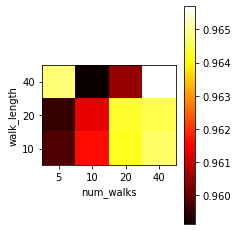

In [32]:
plt.figure(figsize=(3, 4))
node_dim = 10
# you should have an auc score dictionary here.
a = np.array( [ (0.964782  ,0.959141  ,0.960523 ,0.965694 ),
            (0.959553  ,0.961295  ,0.964317 ,0.964535 ),
           (0.959810,0.961637  ,0.964211  ,0.964695  )] )
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.yticks(ticks=[0,1,2], labels=[40, 20, 10])
plt.ylabel("walk_length")
plt.xticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.xlabel("num_walks")